<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
# !pip install gdown -q

In [2]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

In [3]:
# import zipfile

# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [4]:
RANDOM_STATE = 42

In [5]:
# ваш код здесь
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (1 колонка - индекс из СУБД)
features = pd.read_csv('./content/ДЗ по Uplift обновленное/AGGS_FINAL.csv', index_col=0)
features['user_id'] = features['user_id'].astype('int64')
features.set_index(['user_id', 'report_dt'], inplace=True)

contracts = pd.read_csv('./content/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv', index_col=0)
contracts['user_id'] = contracts['user_id'].astype('int64')
contracts.set_index('contract_id', inplace=True)

campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/CAMPAINGS.csv', index_col=0)
campaigns.set_index('campaing_id', inplace=True)

people_in_campaigns = pd.read_csv('./content/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col=0)
people_in_campaigns['user_id'] = people_in_campaigns['user_id'].astype('int64')
people_in_campaigns.set_index(['user_id', 'campaing_id'], inplace=True)

# Преобразование временных столбцов
for df in [features, contracts, people_in_campaigns]:
    for col in df.columns:
        if '_date' in col or '_dt' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

### Сломанная кампания `idclip`

Проверим есть ли пересечение пользователей по кампаниям

In [6]:
campaigns_set = set(campaigns.index.unique())
cross_campaigns = []
for camp1 in campaigns_set:
    for camp2 in campaigns_set - {camp1}:
        # Получаем пользователей из первой кампании
        users_camp1 = set(people_in_campaigns.query('campaing_id == @camp1').index.get_level_values('user_id').unique())
        
        # Получаем пользователей из второй кампании
        users_camp2 = set(people_in_campaigns.query('campaing_id == @camp2').index.get_level_values('user_id').unique())
        
        # Находим пересечение пользователей между кампаниями
        common_users = users_camp1.intersection(users_camp2)
        
        # Если есть пересечение, добавляем информацию в список
        if len(common_users) > 0:
            cross_campaigns.append({
                'campaign1': camp1,
                'campaign2': camp2,
                'common_users_count': len(common_users),
                'percent_of_camp1': len(common_users) / len(users_camp1) * 100,
                'percent_of_camp2': len(common_users) / len(users_camp2) * 100
            })

# Создаем DataFrame из списка пересечений и выводим результаты
cross_df = pd.DataFrame(cross_campaigns)
if not cross_df.empty:
    print("Пересечения пользователей между кампаниями:")
    print(cross_df.sort_values('common_users_count', ascending=False))
else:
    print("Пересечений пользователей между кампаниями не обнаружено.")



Пересечения пользователей между кампаниями:
  campaign1 campaign2  common_users_count  percent_of_camp1  percent_of_camp2
0     iddqd    idclip               60000              37.5              50.0
1    idclip     iddqd               60000              50.0              37.5


In [7]:
# Пересечания есть, тогда проанализируем детальнее

# Выбираем пользователей из контрольной группы idclip и таргета iddqd
idclip_control = people_in_campaigns.query('campaing_id == "idclip" and t_flag == 0').index.get_level_values('user_id').tolist()
iddqd_target = people_in_campaigns.query('campaing_id == "iddqd" and t_flag == 1').index.get_level_values('user_id').tolist()
# Находим пересечение
common_users = set(idclip_control).intersection(set(iddqd_target))

print(f'Пользователи в контрольной группе idclip:            {len(idclip_control)}')
print(f'Пользователи в целевой группе iddqd:                 {len(iddqd_target)}')
print(f'Пользователи, которые находятся в обеих группах:     {len(common_users)}')
print(f'Процент пересечения контроля idclip и таргета iddqd: {len(common_users) / len(idclip_control) * 100:.2f}%')
print("\n")

# Проверим в обратную сторону
# Выбираем пользователей из ЦЕЛЕВОЙ группы idclip и контрольной группы iddqd
idclip_target = people_in_campaigns.query('campaing_id == "idclip" and t_flag == 1').index.get_level_values('user_id').tolist()
iddqd_control = people_in_campaigns.query('campaing_id == "iddqd" and t_flag == 0').index.get_level_values('user_id').tolist()
common_users2 = set(idclip_target).intersection(set(iddqd_control))

print(f'Пользователи в контрольной группе iddqd:             {len(iddqd_control)}')
print(f'Пользователи в целевой группе idclip:                 {len(idclip_target)}')
print(f'Пользователи, которые находятся в обеих группах:     {len(common_users2)}')
print(f'Процент пересечения целевой idclip и контрольной iddqd: {len(common_users2) / len(idclip_target) * 100:.2f}%')


Пользователи в контрольной группе idclip:            60000
Пользователи в целевой группе iddqd:                 80000
Пользователи, которые находятся в обеих группах:     60000
Процент пересечения контроля idclip и таргета iddqd: 100.00%


Пользователи в контрольной группе iddqd:             80000
Пользователи в целевой группе idclip:                 60000
Пользователи, которые находятся в обеих группах:     0
Процент пересечения целевой idclip и контрольной iddqd: 0.00%


> ⚠️ **ВАЖНО**  
> Кампанию `idclip` невозможно использовать, т.к. **все** пользователи контрольной группы оказались в целевой группе другой кампании, где на них было воздействие. Т.е. контрольной группы де-факто не существует.

Удалим эту кампанию, а ее планировщикам поставим на вид, т.к. SMS - это самый дорогой канал рассылки и деньги потрачены впустую.

In [8]:
# Удаляем кампанию idclip из датасета
campaigns.drop(index='idclip', inplace=True, errors='ignore')
people_in_campaigns.drop(index='idclip', level='campaing_id', inplace=True, errors='ignore')


### Анализ кампаний

In [9]:
# Функции для обработки данных о кампаниях

import scipy.stats


def prepare_campaign_data(campaing_id: str):
    """
    Подготовка данных для конкретной кампании.
    Добавляет поле target и city
    """
    # Определение значения таргета согласно бизнес-правилу
    f = lambda row: (
        # 21 день с начала месяца - для контрольной группы
        pd.Timestamp('2024-11-01') + pd.Timedelta(days=21) > row['contract_date'] >= pd.Timestamp('2024-11-01')
        if row['t_flag'] == 0
        # 14 дней после воздействия - для целевой группы
        else row['delivery_date'] + pd.Timedelta(days=14) > row['contract_date'] >= row['delivery_date']
    )

    # Объединяем данные о людях в кампании с данными о договорах
    merged_data = people_in_campaigns.query('campaing_id == @campaing_id').merge(contracts, on='user_id', how='left')

    # Добавляем поле target (0 или 1)
    merged_data['target'] = merged_data.apply(f, axis=1).astype(int)

    # Добавляем поле city (для анализа по городам)
    user_id_city = features.query('report_dt == "2024-11-30"')['city'].reset_index(drop=False)
    merged_data_2 = merged_data.merge(user_id_city, on='user_id', how='left')

    return merged_data_2


def analyze_campaigns():
    """
    Анализ всех кампаний по продукту 0001
    """
    results = []
    
    # Обходим все кампании по продукту 1 (они там и так все, но как бы обобщаем)
    for campaing_id in campaigns.query('product_id == 1').index.tolist():
        campaign_data = prepare_campaign_data(campaing_id)
        
        # Базовые метрики
        treatment_conversion = campaign_data.query('t_flag == 1')['target'].mean()
        control_conversion = campaign_data.query('t_flag == 0')['target'].mean()
        uplift = treatment_conversion - control_conversion
        
        # Проверка корректности данных
        has_both_groups = (campaign_data['t_flag'].nunique() == 2)  # должны быть обе группы - целевая и контрольная
        has_delivery_dates = campaign_data.query('t_flag == 1')['delivery_date'].notna().all()  # даты воздействия должны быть все

        # Проверка на баланс городов
        city_counts = campaign_data.groupby(['t_flag', 'city']).size().unstack().fillna(0)
        chi2, p_value, dof, expected = scipy.stats.chi2_contingency(city_counts)
        is_balanced = p_value > 0.05  # Считаем группы сбалансированными, если p-value > 0.05

        results.append({
            'campaing_id': campaing_id,
            'channel': campaigns.loc[campaing_id]['channel'],
            'treatment_size': len(campaign_data[campaign_data['t_flag'] == 1]),
            'control_size': len(campaign_data[campaign_data['t_flag'] == 0]),
            'treatment_conversion': treatment_conversion,
            'control_conversion': control_conversion,
            'uplift': uplift,
            'p_value': p_value,
            'chi2': chi2,
            'is_valid': has_both_groups and has_delivery_dates,
            'is_balanced': is_balanced,
            'campaign_data': campaign_data
        })
    
    return pd.DataFrame(results)

In [10]:
# Выполнение анализа
campaign_analysis = analyze_campaigns()

# Сохраним на всякий случай
with open('campaign_analysis.json', 'w') as f:
    f.write(campaign_analysis.to_json(orient='records'))

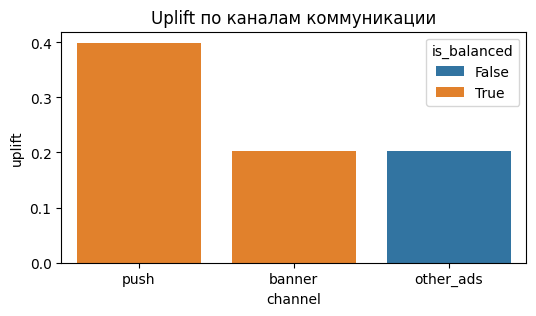


Анализ кампаний:


,campaing_id,channel,treatment_size,control_size,treatment_conversion,control_conversion,uplift,p_value,chi2,is_valid,is_balanced,campaign_data
0,iddqd,push,80000,80000,0.601738,0.202150,0.399588,0.536227,1.246397,True,True,user_id t_flag delivery_date contract...
1,iddt,banner,60000,60000,0.602717,0.400733,0.201983,0.752009,0.570014,True,True,user_id t_flag delivery_date contract...
2,idkfa,other_ads,60000,60000,0.602717,0.400733,0.201983,0.000000,8626.648719,True,False,user_id t_flag delivery_date contract...


In [11]:
# Визуализация результатов
plt.figure(figsize=(6, 3))
sns.barplot(data=campaign_analysis, x='channel', y='uplift', hue='is_balanced')
plt.title('Uplift по каналам коммуникации')
plt.show()

print("\nАнализ кампаний:")
campaign_analysis

### Анализ по городам

На предыущем шаге выявлен дисбаланс по городам в одной кампании. Изучим внимательнее ...

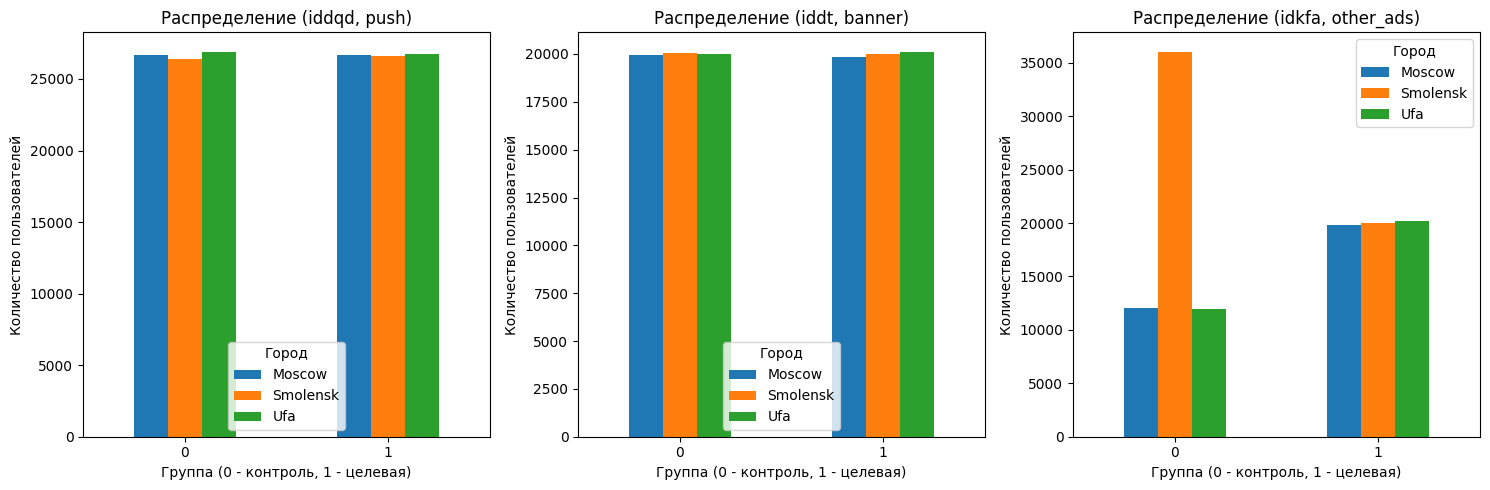

In [12]:
# Распределение пользователей по городам в тестовой и контрольной группах
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, campaign_id in enumerate(campaign_analysis['campaing_id']):
    campaign_data = campaign_analysis.loc[i, 'campaign_data']
    channel = campaign_analysis.loc[i, 'channel']
    
    city_counts = campaign_data.groupby(['t_flag', 'city']).size().unstack()
    
    city_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Распределение ({campaign_id}, {channel})')
    axes[i].set_xlabel('Группа (0 - контроль, 1 - целевая)')
    axes[i].set_ylabel('Количество пользователей')
    axes[i].legend(title='Город')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



**Вывод**  
В кампании `idkfa` наблюдается сильное искажение распределения контрольной и целевой групп по городам.

| campaing_id | channel | treatment_size | control_size | treatment_conversion | control_conversion | p_value | chi2 |
|-------------|---------|----------------|--------------|----------------------|-------------------|---------|------|
| iddqd | push | 80000 | 80000 | 0.601738 | 0.202150 | 0.536227 | 1.246397 |
| iddt | banner | 60000 | 60000 | 0.602717 | 0.400733 | 0.752009 | 0.570014 |
| idkfa | other_ads | 60000 | 60000 | 0.602717 | 0.400733 | 0.000000 | 8627 |

Хи-квадрат (критерий Пирсона) достигает 8627 при числе пользователей в группах порядка 20,000 - это много.  
Так же `p-value = 0`, что говорит что есть статистически значимые различия в распределении городов между группами (дисбаланс).

Выглядит как ошибка формирования контрольной группы по городам, когда по 8тыс. контрольных пользователей вместо Москвы и Уфы взяты в Смоленске, где покупательная способность явно ниже даже. Это исказит результаты моделирования.

> ⚠️ **ВАЖНО**  
> Кампанию `idkfa` тоже не будем использовать. 

In [13]:
# Удаляем кампанию idkfa из датасета
campaigns.drop(index='idkfa', inplace=True, errors='ignore')
people_in_campaigns.drop(index='idkfa', level='campaing_id', inplace=True, errors='ignore')
campaign_analysis = campaign_analysis[campaign_analysis['campaing_id'] != 'idkfa']


### Итоговая таблица

In [14]:
campaign_analysis

,campaing_id,channel,treatment_size,control_size,treatment_conversion,control_conversion,uplift,p_value,chi2,is_valid,is_balanced,campaign_data
0,iddqd,push,80000,80000,0.601738,0.202150,0.399588,0.536227,1.246397,True,True,user_id t_flag delivery_date contract...
1,iddt,banner,60000,60000,0.602717,0.400733,0.201983,0.752009,0.570014,True,True,user_id t_flag delivery_date contract...


In [15]:
# Создаем пустой список для хранения данных
all_campaigns_data = []

# Проходим по всем кампаниям
for _, row in campaign_analysis.iterrows():
    campaign_data = row['campaign_data']
    
    # Формируем таблицу для каждой кампании
    campaign_table = pd.DataFrame({
        'client_id': campaign_data['user_id'],
        'campaing_id': row['campaing_id'],
        'target': campaign_data['target'],
        'treatment_group_key': campaign_data['t_flag'],
        
        # Устанавливаем последний день месяца как report_dt
        'report_dt': pd.to_datetime('2024-11-30')  
    })
    
    all_campaigns_data.append(campaign_table)

# Объединяем все данные
final_table = pd.concat(all_campaigns_data, ignore_index=True)

print("Итоговая таблица (head):")
print(final_table.head())
print("\nРазмерность таблицы:", final_table.shape)
print("\nРаспределение целевой переменной по кампаниям:")

# Распределение целевой переменной по кампаниям
print(final_table.groupby(by='campaing_id')['target'].value_counts(normalize=True))


Итоговая таблица (head):
   client_id campaing_id  target  treatment_group_key  report_dt
0       1162       iddqd       1                    1 2024-11-30
1      42991       iddqd       0                    1 2024-11-30
2      24623       iddqd       0                    0 2024-11-30
3     116064       iddqd       1                    0 2024-11-30
4     139714       iddqd       0                    0 2024-11-30

Размерность таблицы: (280000, 5)

Распределение целевой переменной по кампаниям:
campaing_id  target
iddqd        0         0.598056
             1         0.401944
iddt         1         0.501725
             0         0.498275
Name: proportion, dtype: float64


### Выводы

0. **Сломанные кампании** - по причине ошибок при формировании групп пользователей по городам
   1. `idclip`
      - Тут вся контрольная группа оказалась целевой группой другой кампании (`iddqd`). Невозможно оценить конверсию и uplift.
      - Пересечений клиентов больше нет.
   2. `idkfa`
      - Тут сильный дисбаланс между городами в контрольной группе (`p-value = 0`, Хи-квадрат = 8627). Возможно искажение эффекта воздействия из-за разницы покупательной способности в городах.

**Для остальных кампаний...**
| campaing_id | channel | treatment_size | control_size | treatment_conversion | control_conversion | uplift | is_valid |
|-------------|---------|----------------|--------------|----------------------|--------------------|--------|----------|
| iddqd | push | 80000 | 80000 | 0.601738 | 0.202150 | 0.399588 | True |
| iddt | banner | 60000 | 60000 | 0.602717 | 0.400733 | 0.201983 | True |

1. **Общая структура данных**:
   - Общий размер итоговой таблицы: 280,000 записей (после удаления `idclip` и `idkfa`)
   - Размер групп варьируется: 80,000 клиентов для push-уведомлений и 60,000 для остальных каналов
   - Каждая кампания
     - содержит обе группы (целевая и контрольная)
     - группы сбалансированы по городам (более-менее)
     - нет пропусков в данных
     - нет пересечений по пользователям

2. **Эффективность каналов коммуникации**:
   - Push-уведомления (iddqd) показали хороший uplift: +0.399 (39.9%)
     * Конверсия в целевой группе: 60.2%
     * Конверсия в контрольной группе: 20.2%
   - Banner (iddt) показали приемлемый uplift: +0.202 (20.2%)
     * Конверсия в целевой группе: 60.3%
     * Конверсия в контрольной группе: 40.1%



<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [16]:
# Кампании проводились в ноябре 2024
# Нам нужны агрегаты за сентябрь 2024 (смещение на 2 месяца)
target_date = pd.to_datetime('2024-09-30')

# Получаем агрегаты за нужный месяц
features_for_model = features.query('report_dt == @target_date.strftime("%Y-%m-%d")')

# Объединяем с нашей таблицей результатов кампаний
merged_data = final_table.merge(
    features_for_model,
    left_on='client_id',
    right_on='user_id',
    how='left'
)

In [17]:
merged_data.head()

,client_id,campaing_id,target,treatment_group_key,report_dt,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,1162,iddqd,1,1,2024-11-30,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,39,Moscow
1,42991,iddqd,0,1,2024-11-30,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow
2,24623,iddqd,0,0,2024-11-30,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa
3,116064,iddqd,1,0,2024-11-30,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,33,Ufa
4,139714,iddqd,0,0,2024-11-30,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,27,Ufa


Приличную часть EDA мы уже проделали (и устранили проблемы) при выявлении аномальных кампаний.
Осталось проанализировать добавленные признаки.

In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280000 entries, 0 to 279999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            280000 non-null  int64         
 1   campaing_id          280000 non-null  object        
 2   target               280000 non-null  int64         
 3   treatment_group_key  280000 non-null  int64         
 4   report_dt            280000 non-null  datetime64[ns]
 5   x1                   280000 non-null  float64       
 6   x2                   280000 non-null  float64       
 7   x3                   280000 non-null  float64       
 8   x4                   280000 non-null  float64       
 9   x5                   280000 non-null  float64       
 10  x6                   280000 non-null  float64       
 11  x7                   280000 non-null  float64       
 12  x8                   280000 non-null  float64       
 13  x9            

In [19]:
df_iddqd = merged_data.query('campaing_id == "iddqd"')
df_iddt = merged_data.query('campaing_id == "iddt"')

numeric_features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

### Анализ числовых признаков

#### ... в кампании `iddqd`

In [20]:
df_iddqd.groupby(by='treatment_group_key')[numeric_features].mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,0.604476,0.991262,0.989826,-0.606210,0.592924,-0.002248,-0.002248,-0.000358,0.524898,32.504013
1,0.601202,1.004994,0.996935,-0.596487,0.601505,-0.002147,-0.004232,-0.003318,0.523636,32.448462


In [21]:
df_iddqd.groupby(by='treatment_group_key')[numeric_features].median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,0.690167,0.991941,0.991280,-0.698398,0.715804,0.000645,-0.208016,-0.561839,0.575092,32.0
1,0.684945,1.003702,0.994629,-0.683922,0.723315,-0.003707,-0.208410,-0.561366,0.573658,32.0


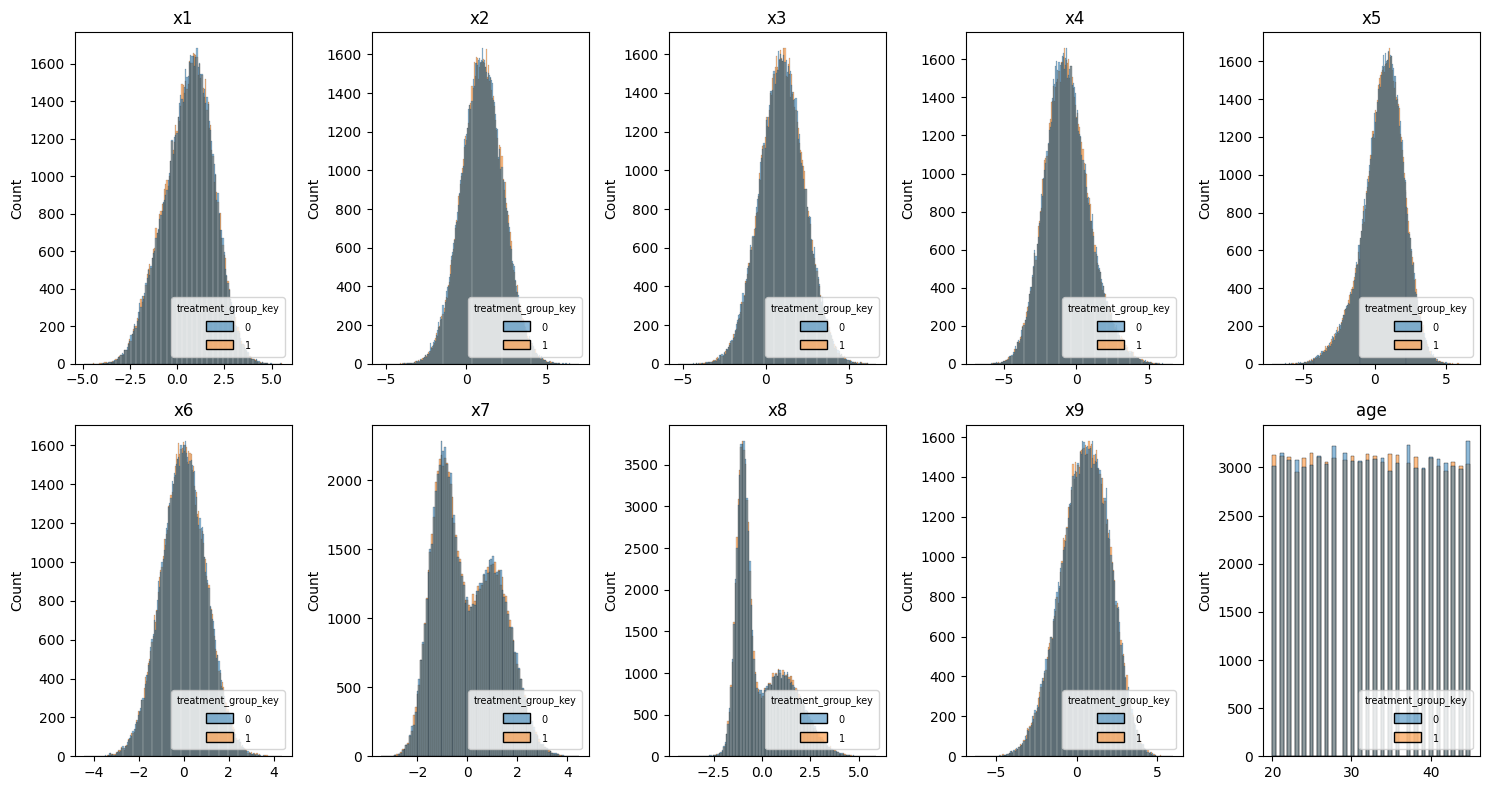

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=df_iddqd, x=col, hue='treatment_group_key', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

    # Получаем и настраиваем легенду
    legend = axes[i].get_legend()
    if legend is not None:
        plt.setp(legend.get_texts(), fontsize='x-small')
        plt.setp(legend.get_title(), fontsize='x-small')
        # legend.set_bbox_to_anchor((1, 1))
        legend.set_loc('lower right')


plt.tight_layout()
plt.show()

Наблюдаем ненормальное распределение в признаках `x7`, `x8`.

Хотя таргет распределен довольно похоже между контрольной и целевой группой, присутствует заметное расхождение средних для признаков `x7`, `x8`, при этом медианы очень близки.

Проверим, насколько эти различия статистически значимы. Полагаем уровень статзначимости 0.05, нулевая гипотеза - различий между группами нет, альтернативная - различия между группами есть.

In [23]:
df_1 = df_iddqd.drop(columns = ['target'])
df_1.treatment_group_key = df_1.treatment_group_key.astype('str')
df_1.treatment_group_key = df_1.treatment_group_key.replace({'0':'control',
                                                             '1':'test'})
df_1 = df_1.rename(columns={'treatment_group_key':'group'})

In [24]:
from psi import calculate_psi


for col in numeric_features:
    psi = calculate_psi(expected = df_1[df_1.group == 'control'][col],
                        actual = df_1[df_1.group == 'test'][col])
    print(f'psi для признака {col} равно {psi}')

psi для признака x1 равно 0.0002767697206009882
psi для признака x2 равно 0.00021561756105683059
psi для признака x3 равно 0.00019081748867860477
psi для признака x4 равно 0.000263721441935588
psi для признака x5 равно 0.00021383738927209807
psi для признака x6 равно 0.000213586268918342
psi для признака x7 равно 0.00016454908827573533
psi для признака x8 равно 0.0003232298576233026
psi для признака x9 равно 5.2528171787091363e-05
psi для признака age равно 0.00023436883870353193


Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1)

#### ... в кампании `iddt`

In [25]:
df_iddt.groupby(by='treatment_group_key')[numeric_features].mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,-0.200788,-1.005438,0.195224,-0.201540,0.005851,-0.000878,0.335597,0.333879,-0.231895,32.531317
1,-0.190153,-0.996064,0.201646,-0.199495,-0.003222,0.002184,0.335707,0.332511,-0.234196,32.500350


In [26]:
df_iddt.groupby(by='treatment_group_key')[numeric_features].median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
treatment_group_key,,,,,,,,,,
0,-0.039344,-1.000710,0.15114,-0.191527,0.004826,0.001446,0.520809,0.712336,-0.245529,33.0
1,-0.029260,-0.992088,0.16389,-0.182136,-0.004370,0.006098,0.513940,0.719739,-0.246031,33.0


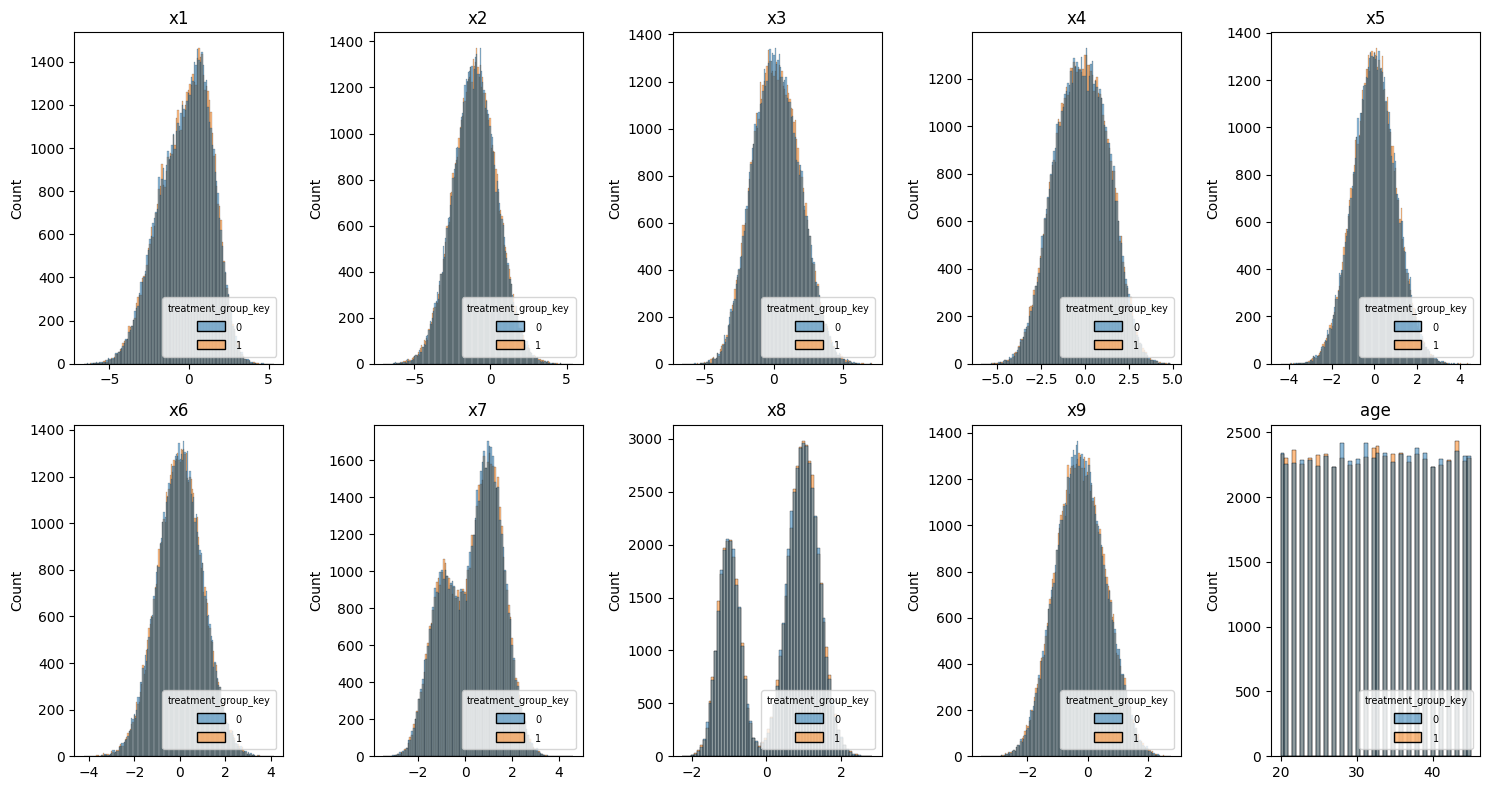

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=df_iddt, x=col, hue='treatment_group_key', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

    # Получаем и настраиваем легенду
    legend = axes[i].get_legend()
    if legend is not None:
        plt.setp(legend.get_texts(), fontsize='x-small')
        plt.setp(legend.get_title(), fontsize='x-small')
        # legend.set_bbox_to_anchor((1, 1))
        legend.set_loc('lower right')


plt.tight_layout()
plt.show()

Аналогично, наблюдаем ненормальное распределение в признаках `x7`, `x8`.

Аналогично, таргет распределен довольно похоже между контрольной и целевой группой, но присутствует заметное расхождение средних для признаков `x5`, `x6`.

Проверим, насколько эти различия статистически значимы.

In [28]:
df_2 = df_iddt.drop(columns = ['target'])
df_2.treatment_group_key = df_2.treatment_group_key.astype('str')
df_2.treatment_group_key = df_2.treatment_group_key.replace({'0':'control',
                                                             '1':'test'})
df_2 = df_2.rename(columns={'treatment_group_key':'group'})

In [29]:
from psi import calculate_psi


for col in numeric_features:
    psi = calculate_psi(expected = df_2[df_2.group == 'control'][col],
                        actual = df_2[df_2.group == 'test'][col])
    print(f'psi для признака {col} равно {psi}')

psi для признака x1 равно 0.00037535361678774667
psi для признака x2 равно 0.0002901716652298453
psi для признака x3 равно 0.00017972873626892868
psi для признака x4 равно 0.00010456081630883393
psi для признака x5 равно 0.00024344837218884743
psi для признака x6 равно 0.00015069786233271363
psi для признака x7 равно 0.0004014445700175466
psi для признака x8 равно 0.0003798369821751666
psi для признака x9 равно 0.0004029388769543135
psi для признака age равно 0.00019673831851946722


Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1)

### Анализ категориальных и бинаризованных признаков

Для категориальных переменных (`city`) и непрерывных переменных после бинаризации проверим, насколько сильно отличается среднее значение таргета в контрольной и целевой группе в обучающей выборке. 

Для этого максимально грубо построим прообраз uplift-решающего дерева, то есть найдем признаки и те их значения, которые дают максимальный вклад в uplift по всей выборке и таким образом довольно грубо найдем пользователей, наиболее восприимчивых к коммуникации.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


In [31]:
# Разделим выборки на обучающую и тестовую
train_index_iddqd, test_index_iddqd = train_test_split(df_iddqd.index, test_size=0.25, random_state=RANDOM_STATE)
train_index_iddt, test_index_iddt = train_test_split(df_iddt.index, test_size=0.25, random_state=RANDOM_STATE)

features_to_bin = numeric_features + ['city']

In [32]:
def build_best_uplift(df, feature, df_index):
    '''
    Поиск значений признака, которые дают максимальный вклад в uplift по всей выборке.
    '''
    _df_train =  df.loc[df_index].copy()
    if df[feature].dtype == 'object':
        _df_train[feature + '_bin'] = df[feature]
    else:
        _df_train[feature + '_bin'] = pd.qcut(_df_train[feature], q=6, duplicates='drop')

    tmp = _df_train.groupby(by=[feature + '_bin','treatment_group_key']).agg({'target':'mean'}).reset_index()
    tmp_1 = tmp[tmp['treatment_group_key']==1].drop(columns='treatment_group_key').set_index(feature + '_bin')
    tmp_0 = tmp[tmp['treatment_group_key']==0].drop(columns='treatment_group_key').set_index(feature + '_bin')
    best_uplift = tmp_1 - tmp_0

    # Преобразуем best_uplift в формат с колонками feature, bin, target
    best_uplift = best_uplift.reset_index()
    best_uplift.columns = ['bin', 'best_uplift']
    best_uplift['feature'] = feature
    best_uplift = best_uplift[['feature', 'bin', 'best_uplift']]  # Переупорядочиваем колонки
    
    return best_uplift

In [33]:
# Поиск лучших значений uplift для каждого признака

dfs = {
    'iddqd': (df_iddqd, train_index_iddqd, test_index_iddqd),
    'iddt': (df_iddt, train_index_iddt, test_index_iddt)
}

best_uplifts = {key: pd.DataFrame() for key in dfs}

for i, _df_name in enumerate(dfs):
    for column in features_to_bin:
        feature_uplift = build_best_uplift(dfs[_df_name][0], column, dfs[_df_name][1])
        best_uplifts[_df_name] = pd.concat([best_uplifts[_df_name], feature_uplift], ignore_index=True)

/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_73469/2346271192.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = _df_train.groupby(by=[feature + '_bin','treatment_group_key']).agg({'target':'mean'}).reset_index()
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_73469/2346271192.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = _df_train.groupby(by=[feature + '_bin','treatment_group_key']).agg({'target':'mean'}).reset_index()
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_73469/2346271192.py:11: FutureWarning: The default of observed=False is deprecated and 

In [34]:
def visualize_best_uplifts(best_uplifts_):
    """
    Визуализация лучших значений uplift для каждого признака
    
    Parameters:
    -----------
    best_uplifts_ : pandas.DataFrame
        DataFrame с данными о лучших значениях uplift для каждого признака
    """
    plt.figure(figsize=(15, 15))

    # Получаем уникальные признаки
    unique_features = best_uplifts_['feature'].unique()
    n_features = len(unique_features)

    # Определяем количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    # Создаем подграфики
    for i, feature in enumerate(unique_features):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        
        # Фильтруем данные для текущего признака
        feature_data = best_uplifts_[best_uplifts_['feature'] == feature]
        
        # Строим bar plot с категориями бинов
        sns.barplot(x=feature_data.index, y='best_uplift', data=feature_data, ax=ax)
        # Устанавливаем метки оси X как строковые представления бинов
        bin_labels = [str(b) for b in feature_data['bin']]
        ax.set_xticks(range(len(bin_labels)))
        ax.set_xticklabels(bin_labels, rotation=90, ha='right')
        
        ax.set_title(f'Uplift для признака {feature}')
        ax.set_ylabel('Uplift')
        ax.set_xlabel('')
        
        # Ставим значения uplift над столбцами
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'bottom', 
                       xytext = (0, 1), textcoords = 'offset points')

    plt.tight_layout()
    plt.show()


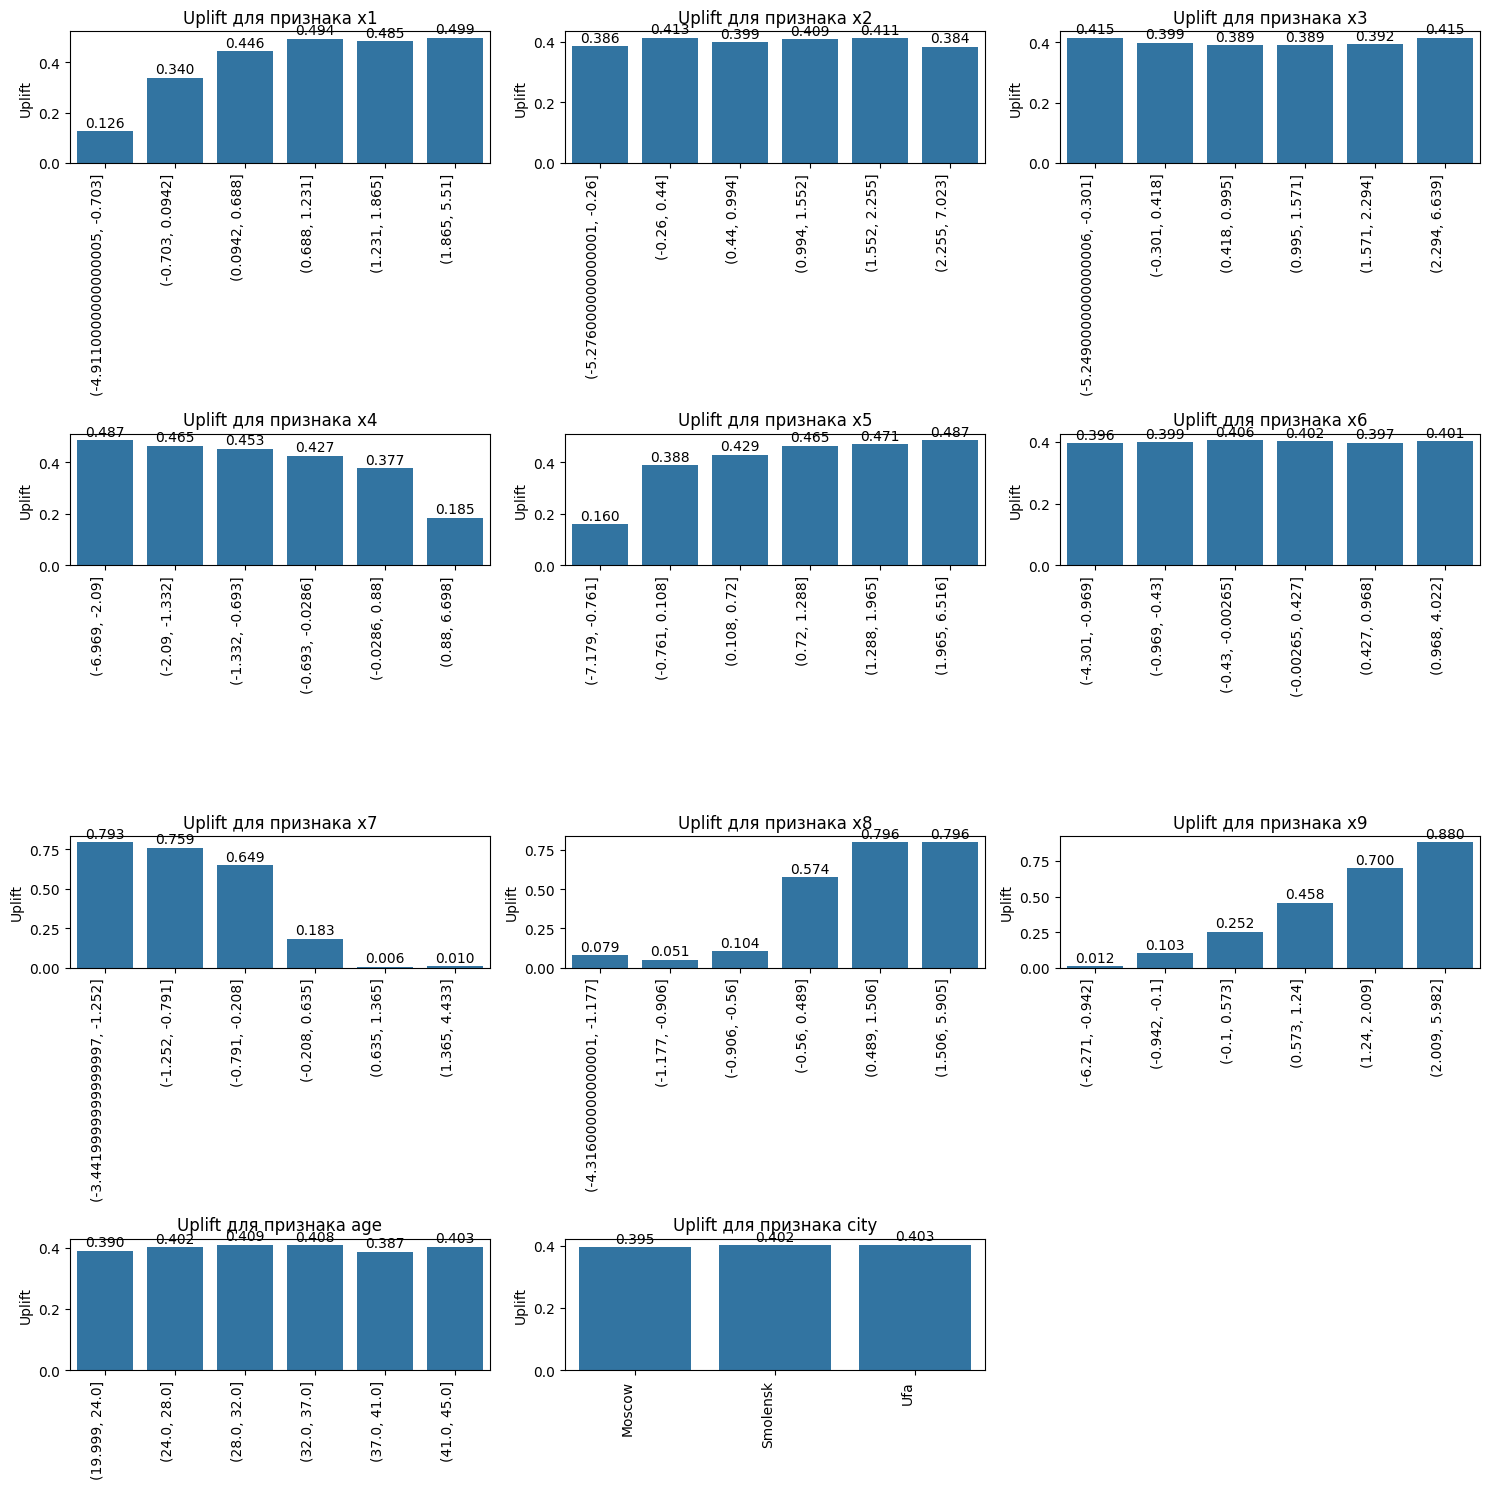

In [35]:
# Визуализация значений uplift для признаков
visualize_best_uplifts(best_uplifts['iddqd'])


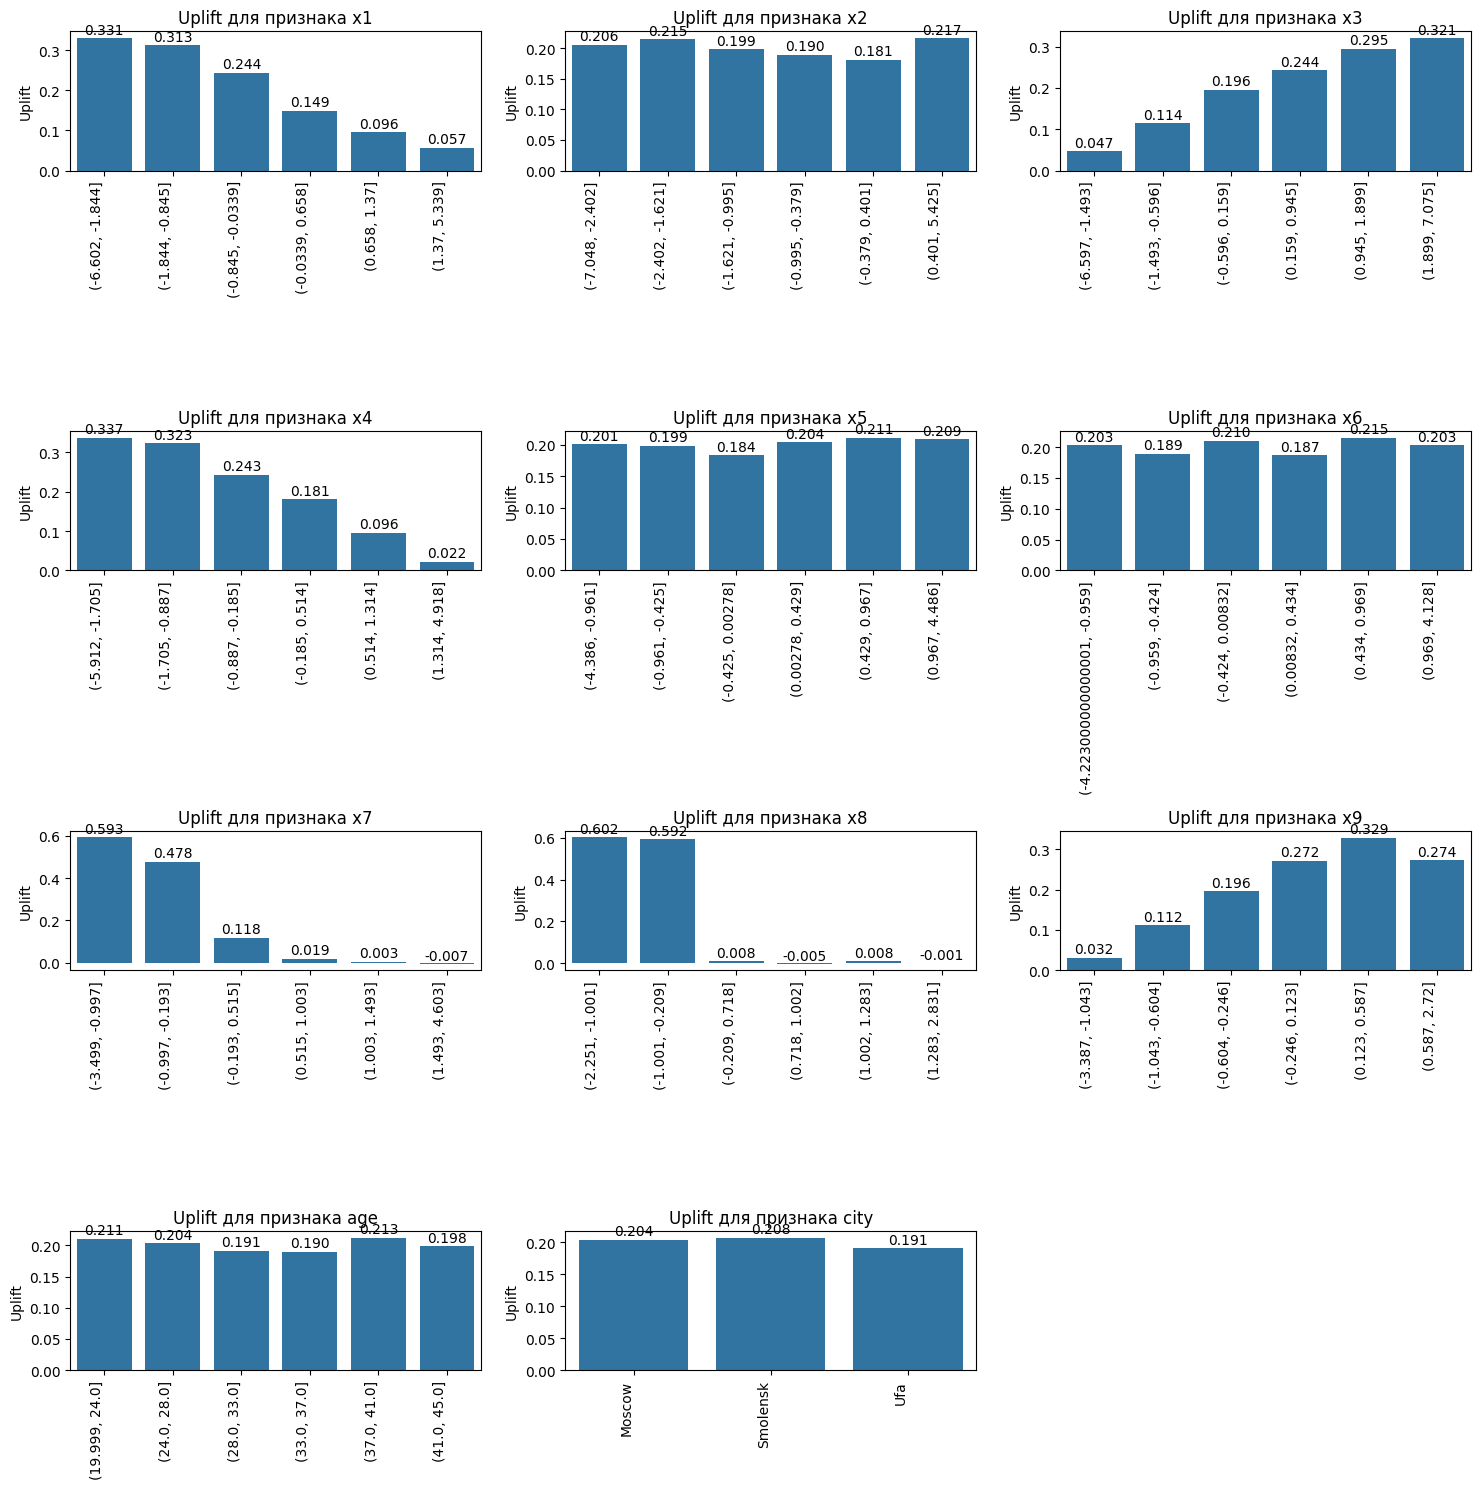

In [36]:
visualize_best_uplifts(best_uplifts['iddt'])

In [37]:
# Топ-5 комбинаций признак-бин с наибольшим uplift
top_bins_iddqd = best_uplifts['iddqd'].sort_values(by='best_uplift', ascending=False).head(5)
print("\niddqd: Топ-5 комбинаций признак-бин с наибольшим uplift:")
print(top_bins_iddqd)

top_bins_iddt = best_uplifts['iddt'].sort_values(by='best_uplift', ascending=False).head(5)
print("\niddt: Топ-5 комбинаций признак-бин с наибольшим uplift:")
print(top_bins_iddt)



iddqd: Топ-5 комбинаций признак-бин с наибольшим uplift:
   feature                            bin  best_uplift
53      x9                 (2.009, 5.982]     0.880075
46      x8                 (0.489, 1.506]     0.796167
47      x8                 (1.506, 5.905]     0.795980
36      x7  (-3.4419999999999997, -1.252]     0.792745
37      x7               (-1.252, -0.791]     0.758791

iddt: Топ-5 комбинаций признак-бин с наибольшим uplift:
   feature               bin  best_uplift
42      x8  (-2.251, -1.001]     0.602463
36      x7  (-3.499, -0.997]     0.593038
43      x8  (-1.001, -0.209]     0.592469
37      x7  (-0.997, -0.193]     0.478375
18      x4  (-5.912, -1.705]     0.336678


### Выводы

**Анализ числовых и категориальных признаков**
- Распределения признаков в контрольной и целевой группах очень близки, что говорит о правильном проведении A/B тестов.
- Есть различия в медианных значениях по целевой и контрольной группам отдельных признаков, но эти различия статистической значимости не имеют (PSI<0.1).

**Бинаризация признаков**
Числовые признаки были разбиты на бины для анализа их влияния на uplift.
- Для каждого числового признака были созданы интервалы значений (бины).
- Для категориальных (только `city`) использованы все 3 категории.
- Для каждого бина вычислялся средний показатель конверсии в целевой и контрольной группах.
- На основе конверсий рассчитан uplift.

**Результаты бинаризации**

Топ-5 комбинаций с наибольшим uplift:

Кампания `iddqd` (push):
| Признак | Диапазон | Uplift |
|---------|----------|--------|
| `x9` | (2.009, 5.982] | 0.88 (88%) |
| `x8` | (0.489, 1.506] | 0.80 (80%) |
| `x8` | (1.506, 5.905] | 0.80 (80%) |
| `x7` | (-3.442, -1.252] | 0.79 (79%) |
| `x7` | (-1.252, -0.791] | 0.76 (76%) |

Кампания `iddt` (баннеры):
| Признак | Диапазон | Uplift |
|---------|----------|--------|
| `x8` | (-2.251, -1.001] | 0.60 (60%) |
| `x7` | (-3.499, -0.997] | 0.59 (59%) |
| `x8` | (-1.001, -0.209] | 0.59 (59%) |
| `x7` | (-0.997, -0.193] | 0.48 (48%) |
| `x4` | (-5.912, -1.705] | 0.34 (34%) |

**Выводы по бинаризации**

1. *Значительная нелинейность эффекта воздействия*: 
   - uplift существенно различается между разными диапазонами значений одного и того же признака, что подтверждает правильность использования бинаризации для улучшения качества uplift-моделей.

2. *Наиболее перспективные сегменты*:
   - Для push-уведомлений (iddqd) наибольший uplift у клиентов с высокими значениями признака x9 (uplift до 88%)
   - Для баннеров (iddt) — у клиентов с определенными значениями признака x8 (uplift до 60%)

3. *Различия между каналами коммуникации*:
   - Push-уведомления в целом показывают более высокий uplift по сравнению с баннерами (максимальный uplift 88% против 60%)
   - При этом каналы демонстрируют лучшие результаты на разных сегментах клиентов (разные признаки и их значения)

4. *Роль ключевых признаков*:
   - Признаки x7, x8 и x9 оказались наиболее информативными для обеих кампаний
   - Особенно важны признаки x8 и x7, которые встречаются в топ-5 для обеих кампаний, но в разных диапазонах значений
   - Для кампании с баннерами также значим признак x4 в отрицательном диапазоне

5. *Практические рекомендации*:
   - При таргетировании push-уведомлений стоит фокусироваться на клиентах с высокими значениями x9 и определенными значениями x8
   - Для баннерной рекламы наиболее эффективны будут пользователи с определенными (отрицательными) значениями признаков x8 и x7
   - Некоторые сегменты клиентов показывают очень высокий uplift (до 88%), что делает их приоритетными


<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [ ]:
# ваш код здесь

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь